Multilayer Perceptror Model Building

In [34]:
##Libraries needed

import numpy as np
import pandas as pd
from keras.layers import Dense
import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
#from umap import UMAP
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
from collections import Counter
import numpy as np
import scanpy as sc
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import ast
%reload_ext jupyternotify

<IPython.core.display.Javascript object>

In [59]:
##Directories

dir_data = "E:/AML_project/DATASETS/building/"
dir_meta = "E:/AML_project/METADATA/"
dir_out_data = "E:/AML_project/DATASETS/training/"

#Combination of datasets

# comb = "RvG"
comb = "RGG"
# comb = "CovG"
# comb = "CoGG"

In [60]:
##Loading the pre-formated data (Formating.ipynb)

#Dataframes

    #Cell count file
all_samples =  pd.read_csv(dir_data + "all_samples_" + comb + ".csv", index_col = 0)

    #Annotations
all_anno = pd.read_csv(dir_data + "all_anno_" + comb + ".csv", index_col = 0) 

#Metadata lists

    #Shared genes (intersection)
gene_list = open(dir_meta + "gene_list_" + comb + ".txt", 'r')
gene_list = gene_list.read()
gene_list = ast.literal_eval(gene_list)
shared_genes = np.array(gene_list)

    #Barcodes (cell IDs)
barcodes_general = open(dir_meta + "barcodes_general_" + comb + ".txt", 'r')
barcodes_general = barcodes_general.read()
barcodes_general = ast.literal_eval(barcodes_general)

Data formating

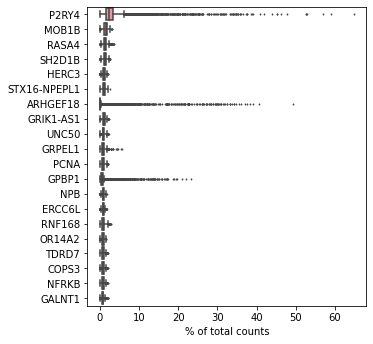

In [61]:
##Creating the anndata object

anndata_all = sc.AnnData(X=all_samples.T.to_numpy(), obs=barcodes_general, var=shared_genes) #transform data to Anndata format with
                                                                                                    #barcodes (cell IDs) as obs and gene names as variables
anndata_all.var_names = shared_genes #change gene # for names
anndata_all.obs_names = barcodes_general #change cell # for cell IDs
anndata_all.raw = anndata_all #*no sé porqué hacen esto
sc.pl.highest_expr_genes(anndata_all, n_top=20, ) #calculate the 20 genes with highest expression

In [62]:
## General data processing to facilitate model efficiency

    #Filtering
# sc.pp.filter_genes(anndata_all, min_cells=80) #filter genes who have very few cells (min = 20), can also be done with cells with few counts

    #Normalization (CPM)
sc.pp.normalize_total(anndata_all, target_sum=1e6) #normalize each cell by total counts over all genes, so that every cell 
                                                   #has the same total count after normalization (target_sum = 1e6 equals CPM normalization) 
    #Transformation (log1p)
sc.pp.log1p(anndata_all) #transformation of the data with a log1p function

    #Visualization
#box and whiskers
# sc.pl.highest_expr_genes(anndata_all, n_top=50) #visualize the 50 highest expressing genes
#PCA


In [63]:
##Preparing the input data of the model

    #Based on the files, generate arrays for categorical data (cell counts, cells and class)
dict_class = dict(zip(all_anno.Cell,all_anno.PredictionRefined)) #generate dictionary with each cell ID associated to its class
y_class = [dict_class[x] for x in anndata_all.obs_names] #generate list with all the classes (variable Y)
X = anndata_all.X #generate array with all the cell counts (X)
X_train = X #**no sé porqué hacen esto
bin_dict = dict(normal=0, unclear = 0, malignant=1) #defining binary values for the class types (0 or 1) when classifing malignant from normal
# bin_dict = dict(normal = 0, malignant = 1) #defining binary values for the class types (0 or 1) when classifing MDS from malignant (AML)
y_true_num = [bin_dict[x] for x in y_class] #based on the list with classes, generating a list with associated binary value (0 or 1)
y_train = np.array(y_true_num) #changing list with class values to array (input format needed)

    #Creating the categorical arrays that will enter the model for training and testing (X, cell counts:Y, cell class (binary))
Xtrain,Xtest,ytrain,ytest=train_test_split(X_train,y_train,test_size=0.2,shuffle=True) #spliting data into the training set and testing set (20% of all data)
encoded_train=to_categorical(ytrain) #encoding file as categorical (training)
encoded_test=to_categorical(ytest) #encoding file as categorical (testing)

    #Defining data shape for model input
genes = Xtrain.shape[1]
Xtrain.shape

(6005, 19830)

Sequential Keras Model (Multilayer Perceptron)

Building the model

In [64]:
##Model construction and training

    #Defining shape of the first layer (tensor) which corresponds to the input
n_input = genes #shape of the initial matrix (number of genes)
n_dim=2 #number of dimensions of the dataset

    #Building the model
model = Sequential()
model.add(Dense(1000,       activation='sigmoid', input_shape=(genes,))) #input size must be the genes measured and the first layer size the cells 
model.add(Dense(800,       activation='sigmoid'))
model.add(Dense(50,       activation='sigmoid'))
model.add(Dense(n_dim,    activation='softmax')) #last layer must  only have size of the number of dimensions of the dataset (2)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(), metrics=["accuracy"]) #compiling the model 
                                                                                                    #optimizer Adam adapts by itself the learning rate

    #Training the model
model.fit(Xtrain,ytrain, batch_size = 120, epochs = 8, verbose = 1) #batch_size= number of samples are included in one batch to be processed in one time (X)
                                                                     #epochs= number of times the model repeats the training with all the data (incresing accuracy)
                                                                     #verbose=  allowing to see output messsages from the model while running (0 = none, 1, 2 = all)

Epoch 1/8
51/51 [==============================] - 3s 44ms/step - loss: 0.5560 - accuracy: 0.7674
Epoch 2/8
51/51 [==============================] - 2s 45ms/step - loss: 0.5171 - accuracy: 0.7803
Epoch 3/8
51/51 [==============================] - 2s 45ms/step - loss: 0.3746 - accuracy: 0.8280
Epoch 4/8
51/51 [==============================] - 2s 48ms/step - loss: 0.0523 - accuracy: 0.9995
Epoch 5/8
51/51 [==============================] - 2s 44ms/step - loss: 0.0120 - accuracy: 1.0000
Epoch 6/8
51/51 [==============================] - 2s 43ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 7/8
51/51 [==============================] - 2s 45ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 8/8
51/51 [==============================] - 2s 44ms/step - loss: 0.0041 - accuracy: 1.0000


Model Testing

47/47 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1192
           1       1.00      1.00      1.00       310

    accuracy                           1.00      1502
   macro avg       1.00      1.00      1.00      1502
weighted avg       1.00      1.00      1.00      1502

[[1192    0]
 [   1  309]]


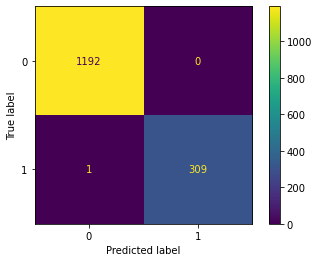

In [65]:
##Model testing with 20% of general dataset

    #Testing the model with the test data
predictions=model.predict(Xtest)

    #Obtaining list of predictions for each sample (probabilities for each class)
pred_label=[]
for p in predictions:  #list of probabilities for being malignant (1) or non-mmalignant (0) based on the model
    pred_label.append(np.argmax(p)) #rounding list of probabilities to the predicted class (1 or 0)

    #Verifying how accurate was the model, comparing the prediction of the test data with the actual classification
print(classification_report(ytest, pred_label)) 
print(confusion_matrix(ytest, pred_label)) #Matrix that compares the predicted labels with the true labels
ConfusionMatrixDisplay.from_predictions(ytest, pred_label) #Turning the martix into a plot
                                                                #X-axis true labels
                                                                #Y-axis predicted labels
plt.show()

Model Validation (individual samples)

        -vanGalen

15/15 [==============================] - 0s 9ms/step


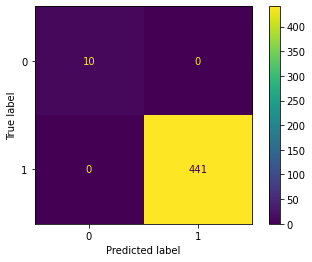

In [46]:
##vGa
vGa = pd.read_csv("E:/AML_project/DATASETS/vanGalen/pacientes/genecounts/D0/GSM3587950_AML419A-D0.dem.txt.gz",sep='\t') #Read file
anno_vGa = pd.read_csv("E:/AML_project/DATASETS/vanGalen/pacientes/annotations/D0/GSM3587951_AML419A-D0.anno.txt.gz",sep='\t') #Read annotations
gene_num_vGa = [i for i, x in enumerate(vGa['Gene']) if x in gene_list] #selecting row numbers of the genes found in the intersection
vGa = vGa.iloc[gene_num_vGa, :] #create dataframe with only the row numbers of the genes found in the intersection
vGa.index = gene_list #change index to list of gene names
lineg_like_cells = ['HSC-like', 'Prog-like', 'GMP-like', 'ProMono-like'] #define lineage-neg-like cells
lineg_cells = ['HSC', 'Prog', 'GMP', 'ProMono'] #define non-lineage cells 
malignant_cells = ['malignant'] #define malignant
nonmalignant_cells = ['normal'] #define non-malignant
num_lineg_like = [i for i,x in enumerate(anno_vGa.CellType) if x in lineg_like_cells]  #selecting row numbers of lineage neg-like cells
num_lineg = [i for i,x in enumerate(anno_vGa.CellType) if x in lineg_cells] #selecting row numbers of lineage-neg cells
num_malignant = [i for i,x in enumerate(anno_vGa.PredictionRefined) if x in malignant_cells]  #selecting row numbers of the malignant cells in annotation file
num_nonmalignant = [i for i,x in enumerate(anno_vGa.PredictionRefined) if x in nonmalignant_cells] #selecting row numbers of the non-malignant cells in annotation file
num_mal_lineg = [x for x in num_malignant if x in num_lineg_like] #listing the row numbers that are lineage negative and malignant
num_nonmal_lineg  = [x for x in num_nonmalignant if x in num_lineg] #listing the row numbers that are lineage negative and malignant
barcodes_vGa = list(anno_vGa.Cell[num_nonmal_lineg]) + list(anno_vGa.Cell[num_mal_lineg]) #creating list with cell IDs of malignant and non-malignant cells to identify them in cell count file
general_col = [i for i,x in enumerate(vGa.columns) if x in barcodes_vGa]  #selecting row numbers of the malignant and non-malignant cells in the cell count file
vGa = vGa.iloc[:,general_col] #Cell counts
anndata_vGa = sc.AnnData(X=vGa.T.to_numpy(), obs=barcodes_vGa, var=shared_genes)
anndata_vGa.var_names = shared_genes #change gene # for names
anndata_vGa.obs_names = barcodes_vGa #change cell # for cell IDs
anndata_vGa.raw = anndata_vGa #*no sé porqué hacen esto
sc.pp.normalize_total(anndata_vGa, target_sum=1e6)
sc.pp.log1p(anndata_vGa)
vGa_data = anndata_vGa.X
predict_vGa = model.predict(vGa_data)
label_vGa=[]
for p in predict_vGa: #list of probabilities for being malignant (1) or non-mmalignant (0) based on the model
    label_vGa.append(np.argmax(p)) #rounding list of probabilities to the predicted class (1 or 0)
ConfusionMatrixDisplay.from_predictions(label_vGa,label_vGa)
plt.show()
# anno = anno_vGa.iloc[general_col,:]
# print(Counter(anno.PredictionRefined))

    -Rodríguez (healthy)

15/15 [==============================] - 0s 9ms/step


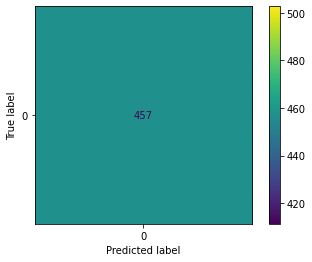

In [34]:
##Rodríguez (healthy only)

Rod = pd.read_csv("E:/AML_project/DATASETS/Rodriguez/sanos/genecounts/healthy4.csv", sep='\t') #Read file

Rod = Rod.rename({'Unnamed: 0': 'Gene'}, axis=1) #Rename gene column
gene_num_rod = [i for i, x in enumerate(Rod['Gene']) if x in gene_list] #selecting row numbers of the genes found in the intersection
df_inter = Rod.iloc[gene_num_rod] #create dataframe with only the row numbers of the genes found in the intersection
Rod = df_inter.sort_values('Gene') #sort gene rows alphabetically to match vanGalen format
Rod.index = gene_list #changing index to gene names (alphabetically ordered) to match vGa data frame indexes
Rod= Rod.drop('Gene', axis=1) #remove gene column
columns = Rod.columns.values #get list of cell IDs (column names)
columns = columns[0:,] #extract cell IDs only (columns, without the first one = gene)
anno_Rod = pd.DataFrame(columns) #create dataframe with cell IDs as rows
anno_Rod = anno_Rod.rename({0: 'Cell'}, axis=1) #name the first column as Cell
anno_Rod = pd.DataFrame(anno_Rod,columns=['Cell','PredictionRefined']) #add columns based on vanGalen annotations (celltype and class)
anno_Rod['PredictionRefined'] = "normal" #define all cells as normal (data is from a healthy individual)
anno_Rod['CellType'] = 'lin-' #define all cells as lin- (data is from lin- cells)
Rod.index = gene_num_rod
barcodes_Rod= Rod.columns.values.tolist()
anndata_Rod = sc.AnnData(X=Rod.T.to_numpy(), obs=barcodes_Rod, var=shared_genes)
anndata_Rod.var_names = shared_genes #change gene # for names
anndata_Rod.obs_names = barcodes_Rod #change cell # for cell IDs
anndata_Rod.raw = anndata_Rod #*no sé porqué hacen esto
sc.pp.normalize_total(anndata_Rod, target_sum=1e6)
sc.pp.log1p(anndata_Rod)
Rod_data = anndata_Rod.X
predict_Rod = model.predict(Rod_data)
label_Rod=[]
for p in predict_Rod: #list of probabilities for being malignant (1) or non-mmalignant (0) based on the model
    label_Rod.append(np.argmax(p)) #rounding list of probabilities to the predicted class (1 or 0)
ConfusionMatrixDisplay.from_predictions(label_Rod,label_Rod)
plt.show()

    -Ganan-Gómez

30/30 [==============================] - 0s 9ms/step


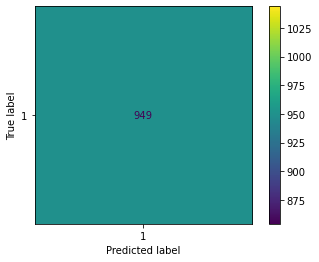

In [58]:
##Ganan-Gómez

GG = pd.read_csv("e:/AML_project/DATASETS/Ganan/pacientes/genecounts/GSM4079128_MDS.txt.gz",sep='\t') #Read file
GG = GG.reset_index() #reset index
GG.rename(columns={'index': 'Gene'}, inplace=True) #name column with genes (previous index) 
for i in range(0, GG.count()[0]): #Formating genes in GG data (eliminate gene ID number)
    GG.at[i,'Gene'] = GG.at[i,'Gene'][16:]
GG = GG.drop_duplicates(['Gene']) #Eliminating gene duplicates (only Ganan-Gómez data has them)
gene_num_GG = [i for i, x in enumerate(GG['Gene']) if x in gene_list] #selecting row numbers of the genes found in the intersection
df_inter = GG.iloc[gene_num_GG] #create dataframe with only the row numbers of the genes found in the intersection
GG = df_inter.sort_values('Gene') #sort gene rows alphabetically to match vanGalen format
GG.index = gene_list #changing index to gene names (alphabetically ordered) to match vGa data frame indexes
GG= GG.drop('Gene', axis=1) #remove gene column
columns = GG.columns.values #get list of cell IDs (column names)
columns = columns[0:,] #extract cell IDs only (columns, without the first one = gene)
anno_GG = pd.DataFrame(columns) #create dataframe with cell IDs as rows
anno_GG  = anno_GG.rename({0: 'Cell'}, axis=1) #name the first column as Cell
anno_GG  = pd.DataFrame(anno_GG ,columns=['Cell','PredictionRefined']) #add columns based on vanGalen annotations (celltype and class)
anno_GG['PredictionRefined'] = "malignant" #define all cells as normal (data is from a healthy individual)
anno_GG['CellType'] = 'lin-' #define all cells as lin- (data is from lin- cells)
GG.index = gene_num_GG
barcodes_GG = GG.columns.values.tolist()
anndata_GG = sc.AnnData(X=GG.T.to_numpy(), obs=barcodes_GG, var=shared_genes)
anndata_GG.var_names = shared_genes #change gene # for names
anndata_GG.obs_names = barcodes_GG #change cell # for cell IDs
anndata_GG.raw = anndata_GG #*no sé porqué hacen esto
sc.pp.normalize_total(anndata_GG, target_sum=1e6)
sc.pp.log1p(anndata_GG)
GG_data = anndata_GG.X
predict_GG = model.predict(GG_data)
label_GG=[]
for p in predict_GG: #list of probabilities for being malignant (1) or non-mmalignant (0) based on the model
    label_GG.append(np.argmax(p)) #rounding list of probabilities to the predicted class (1 or 0)
ConfusionMatrixDisplay.from_predictions(label_GG,label_GG)
plt.show()

    -Colla

41/41 [==============================] - 0s 9ms/step


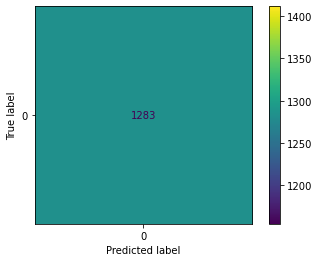

In [59]:
##Colla

Co = pd.read_csv("e:/AML_project/DATASETS/Colla/sanos/genecounts/GSM5212891_HD4-937-Lin-Neg-CD34-Pos.csv.gz") #Read file
df_DC = pd.read_csv('E:/AML_project/DATASETS/Colla/genelist_DC.csv') #read file
genes_DC = df_DC['Gene'].to_list() #generate list of the genes
Co['Gene'] = genes_DC #change gene IDs to gene names (previously obtained)
Co = Co.drop_duplicates(['Gene']) #Eliminating gene duplicates (only Ganan-Gómez data has them)
del Co['Unnamed: 0'] #remove column with gene IDs
gene_num_Co = [i for i, x in enumerate(Co['Gene']) if x in gene_list] #selecting row numbers of the genes found in the intersection
df_inter = Co.iloc[gene_num_Co] #create dataframe with only the row numbers of the genes found in the intersection
Co = df_inter.sort_values('Gene') #sort gene rows alphabetically to match vanGalen format
Co.index = gene_list #changing index to gene names (alphabetically ordered) to match vGa data frame indexes
Co = Co.drop('Gene', axis=1) #remove gene column
columns = Co.columns.values #get list of cell IDs (column names)
columns = columns[0:,] #extract cell IDs only (columns, without the first one = gene)
anno_Co = pd.DataFrame(columns) #create dataframe with cell IDs as rows
anno_Co = anno_Co.rename({0: 'Cell'}, axis=1) #name the first column as Cell
anno_Co = pd.DataFrame(anno_Co,columns=['Cell','PredictionRefined']) #add columns based on vanGalen annotations (celltype and class)
anno_Co['CellType'] = 'lin-' #define all cells as lin- (data is from lin- cells)
anno_Co['PredictionRefined'] = "normal" #define all cells as normal (data is from a healthy individual)
Co.index = gene_num_Co
barcodes_Co = Co.columns.to_list()
anndata_Co = sc.AnnData(X=Co.T.to_numpy(), obs=barcodes_Co, var=shared_genes)
anndata_Co.var_names = shared_genes #change gene # for names
anndata_Co.obs_names = barcodes_Co #change cell # for cell IDs
anndata_Co.raw = anndata_Co #*no sé porqué hacen esto
sc.pp.normalize_total(anndata_Co, target_sum=1e6)
sc.pp.log1p(anndata_Co)
Co_data = anndata_Co.X
predict_Co = model.predict(Co_data)
label_Co=[]
for p in predict_Co: #list of probabilities for being malignant (1) or non-mmalignant (0) based on the model
    label_Co.append(np.argmax(p)) #rounding list of probabilities to the predicted class (1 or 0)
ConfusionMatrixDisplay.from_predictions(label_Co,label_Co)
plt.show()

Saving model outputs

In [60]:
##Array of data used for training and testing

np.save(dir_out_data + "Xtrain_" + comb + ".npy", Xtrain)
np.save(dir_out_data + "ytrain_" + comb + ".npy", ytrain)
np.save(dir_out_data + "Xtest_" + comb + ".npy", Xtest)
np.save(dir_out_data + "ytest_" + comb + ".npy", ytest)

In [14]:
%%notify
print("Finished!")

Finished!


<IPython.core.display.Javascript object>